In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [29]:
# data = pd.read_csv('TANKTEMP092_098.txt',delimiter="\t", header=None, names=["date", "value"])
data = pd.read_csv('TANKTemp060_098.csv',sep=",", header=None, names=["date", "value"])

In [30]:
data.head()

,date,value
0,2015-060-00:00:30.114,18.744939
1,2015-060-00:00:30.882,18.744900
2,2015-060-00:02:38.114,18.785425
3,2015-060-00:02:38.882,18.785400
4,2015-060-00:04:46.114,18.785425


In [31]:
data.shape

(32122, 2)

In [32]:
data['StandardTime']=0
data.head()

,date,value,StandardTime
0,2015-060-00:00:30.114,18.744939,0
1,2015-060-00:00:30.882,18.744900,0
2,2015-060-00:02:38.114,18.785425,0
3,2015-060-00:02:38.882,18.785400,0
4,2015-060-00:04:46.114,18.785425,0


In [33]:
import calendar
import datetime

for i in range(len(data)):
    dd=data['date'][i].split('-')
    yy=int(dd[0])
    jd=int(dd[1])
    sec=dd[2].split(':')
    ss=sec[2][:-4]
    mm=sec[2][-3:]
    month = 1
    day = 0
    while jd - calendar.monthrange(yy,month)[1] > 0 and month <= 12:
        jd = jd - calendar.monthrange(yy,month)[1]
        month = month + 1

    data['StandardTime'][i]=datetime.datetime(yy, month, jd, int(sec[0]),int(sec[1]),int(ss),int(mm)*1000)

In [34]:
data.head()

,date,value,StandardTime
0,2015-060-00:00:30.114,18.744939,2015-03-01 00:00:30.114000
1,2015-060-00:00:30.882,18.744900,2015-03-01 00:00:30.882000
2,2015-060-00:02:38.114,18.785425,2015-03-01 00:02:38.114000
3,2015-060-00:02:38.882,18.785400,2015-03-01 00:02:38.882000
4,2015-060-00:04:46.114,18.785425,2015-03-01 00:04:46.114000


In [106]:
data_std = data.copy()
data_std.head()

,date,value,StandardTime
0,2015-060-00:00:30.114,18.744939,2015-03-01 00:00:30.114000
1,2015-060-00:00:30.882,18.744900,2015-03-01 00:00:30.882000
2,2015-060-00:02:38.114,18.785425,2015-03-01 00:02:38.114000
3,2015-060-00:02:38.882,18.785400,2015-03-01 00:02:38.882000
4,2015-060-00:04:46.114,18.785425,2015-03-01 00:04:46.114000


In [107]:
data_std.drop('date', axis=1, inplace=True)
data_std.head()

,value,StandardTime
0,18.744939,2015-03-01 00:00:30.114000
1,18.744900,2015-03-01 00:00:30.882000
2,18.785425,2015-03-01 00:02:38.114000
3,18.785400,2015-03-01 00:02:38.882000
4,18.785425,2015-03-01 00:04:46.114000


In [108]:
data_std.StandardTime = pd.to_datetime(data_std.StandardTime)
data_std = data_std.set_index('StandardTime')

In [109]:
data_std.head()

,value
StandardTime,
2015-03-01 00:00:30.114,18.744939
2015-03-01 00:00:30.882,18.744900
2015-03-01 00:02:38.114,18.785425
2015-03-01 00:02:38.882,18.785400
2015-03-01 00:04:46.114,18.785425


In [110]:
len(data_std)

32122

In [111]:
data_std.shape

(32122, 1)

Text(0.5, 0, 'Time')

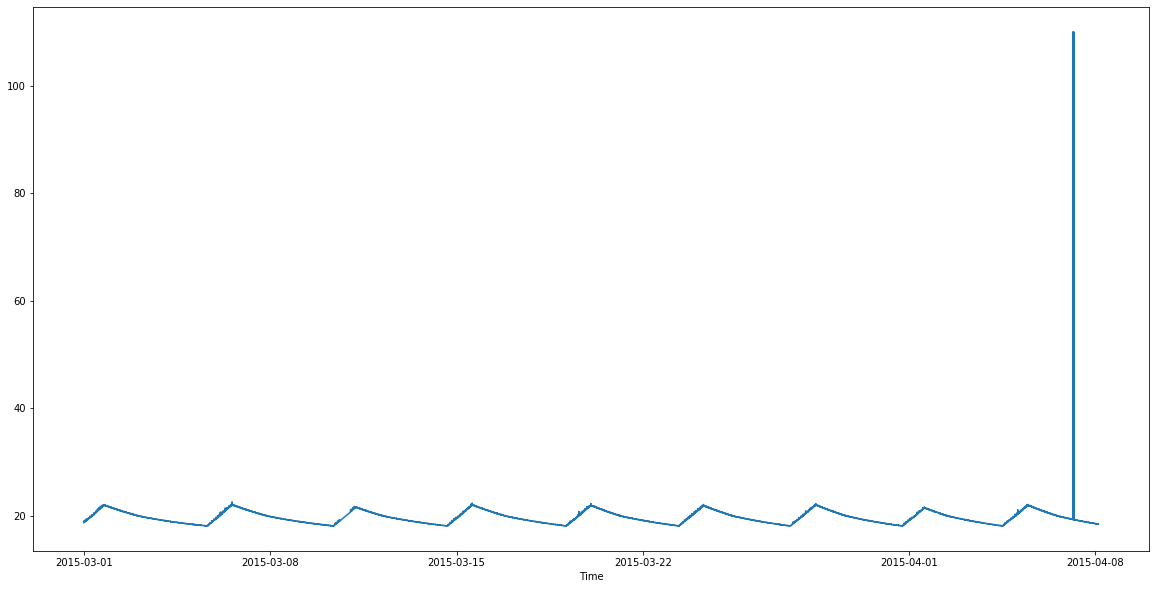

In [112]:
plt.figure(figsize=(20,10))
plt.plot(data_std)
plt.xlabel('Time')

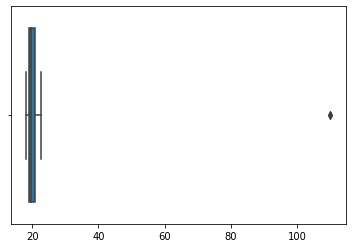

In [113]:
import seaborn as sns

sns.boxplot(data_std)

In [114]:
data_std['value'].max()

110.0

In [115]:
data_std.describe()

,value
count,32119.000000
mean,19.852985
std,1.293697
min,18.137652
25%,18.947368
50%,19.716599
75%,20.752688
max,110.000000


In [116]:
qt = data_std.quantile([.25,.5,.75])
qt

,value
0.25,18.947368
0.50,19.716599
0.75,20.752688


In [117]:
qt1 = data_std.quantile([.25])
qt1=float(qt1.to_numpy())
qt3 = data_std.quantile([.75])
qt3 = float(qt3.to_numpy())
print(qt1,qt3)
print(type(qt3))

18.947368 20.752688
<class 'float'>


In [118]:
float(qt1)

18.947368

In [119]:
qt1+qt3

39.700056000000004

In [120]:
# calculate max value of boxplot
max_box = qt3+(1.5*(qt3-qt1))
max_box

23.460668

In [121]:
# remove outlier
data_std.drop(data_std[data_std['value']>max_box].index, inplace=True)

In [123]:
data_std.head()

,value
StandardTime,
2015-03-01 00:00:30.114,18.744939
2015-03-01 00:00:30.882,18.744900
2015-03-01 00:02:38.114,18.785425
2015-03-01 00:02:38.882,18.785400
2015-03-01 00:04:46.114,18.785425


In [125]:
data_std.shape

(32120, 1)

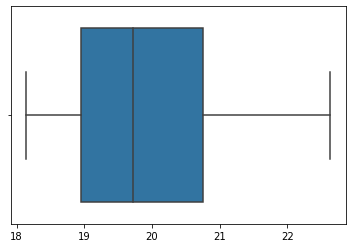

In [126]:
sns.boxplot(data_std)

Text(0.5, 0, 'Time')

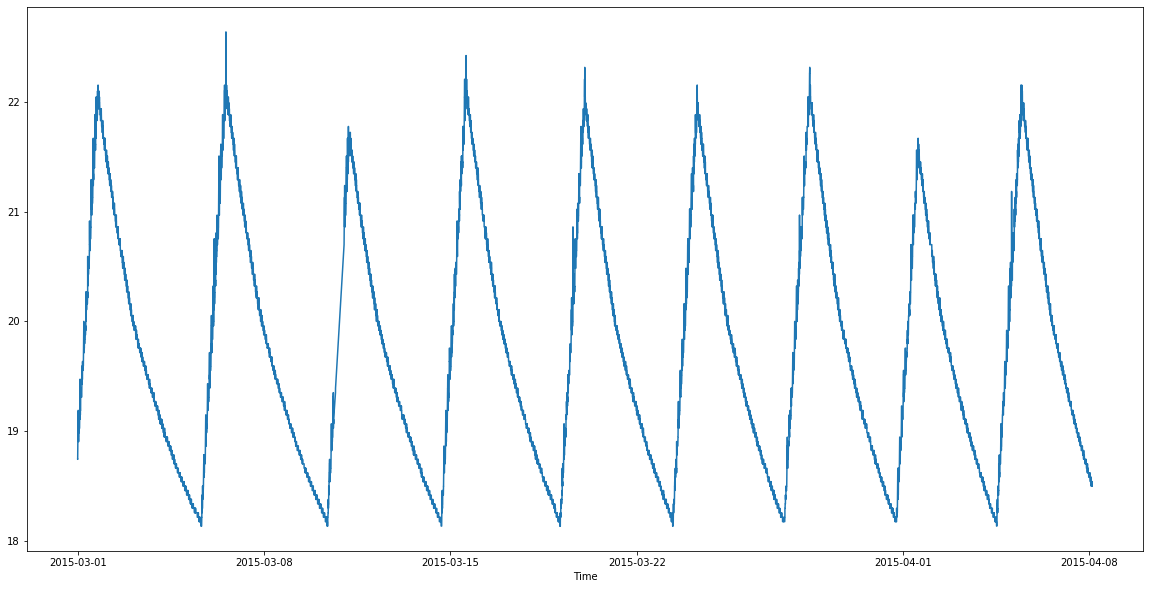

In [127]:
plt.figure(figsize=(20,10))
plt.plot(data_std)
plt.xlabel('Time')

## Distribution 

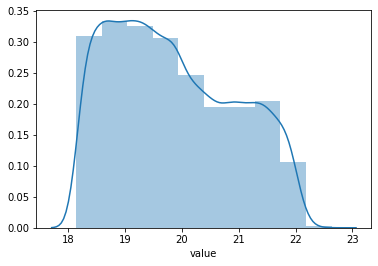

In [155]:
sns.distplot(data_std['value'],bins=10)

In [157]:
# random
import random as rd

data_ran = rd.sample(data_std, k=9000)
# sns.distplot(data_ran['value'],bins=10)

TypeError: Population must be a sequence or set.  For dicts, use list(d).

In [161]:
data_rd = data_std.sample(frac=.75, random_state=9000)
data_rd.head()

,value
StandardTime,
2015-03-03 04:17:34.875,19.919000
2015-03-23 19:06:06.110,19.838057
2015-04-04 20:18:38.103,19.554656
2015-04-07 18:21:18.114,18.785425
2015-03-07 08:26:06.106,20.752688


In [ ]:
data.shape()

In [128]:
df = data_std.copy()
df.head()

,value
StandardTime,
2015-03-01 00:00:30.114,18.744939
2015-03-01 00:00:30.882,18.744900
2015-03-01 00:02:38.114,18.785425
2015-03-01 00:02:38.882,18.785400
2015-03-01 00:04:46.114,18.785425


In [139]:
test_size = 1000
train, test  = df[:-test_size], df[-test_size:]

In [140]:
print('Train size = ' ,train.shape[0])
print('Test size = ' ,test.shape[0])

Train size =  31120
Test size =  1000


In [141]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [147]:
n_input = 12
n_features = 1

generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator, epochs=10)

Epoch 1/10
3111/3111 [==============================] - 32s 10ms/step - loss: nan
Epoch 2/10
3111/3111 [==============================] - 34s 11ms/step - loss: nan
Epoch 3/10
3111/3111 [==============================] - 32s 10ms/step - loss: nan
Epoch 4/10
3111/3111 [==============================] - 32s 10ms/step - loss: nan
Epoch 5/10
3111/3111 [==============================] - 32s 10ms/step - loss: nan
Epoch 6/10
3111/3111 [==============================] - 32s 10ms/step - loss: nan
Epoch 7/10
3111/3111 [==============================] - 32s 10ms/step - loss: nan
Epoch 8/10
3111/3111 [==============================] - 33s 11ms/step - loss: nan
Epoch 9/10
3111/3111 [==============================] - 34s 11ms/step - loss: nan
Epoch 10/10
3111/3111 [==============================] - 34s 11ms/step - loss: nan


In [149]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:, :], [[pred_list[i]]], axis=1)

In [ ]:
from pan

In [151]:
# Normalization the dataset

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(df)

In [152]:
dataset

array([[0.13505026],
       [0.13504159],
       [0.14405366],
       ...,
       [0.09003351],
       [0.09003351],
       [0.08103011]])